Import Packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
# from skimage.morphology import label
# from skimage.feature import structure_tensor
from sklearn.model_selection import train_test_split
# from PIL import Image, ImageDraw
# import cv2

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Project Code/DL_Track-master

/content/drive/.shortcut-targets-by-id/19nWzzidu8Jg7Gd1lC9vD6xLuADKZE5p1/Project Code/DL_Track-master


In [ ]:
# %cd /content/drive/MyDrive/Autumn 2022/CS 230/Project/Project Code/DL_Track-master

In [5]:
!ls

 apo2_weights.csv		     'model_apo_vgg16_1_lr=00001.h5'
 apo2_weights_TEST.csv		     'model_apo_vgg16_1_lr=0.1.h5'
 apo_images			     'model_apo_vgg16_1r_point001=0.001.h5'
 apo_masks			     'model_apo_vgg16_1r_point01=0.01.h5'
 COLAB_Inference_Single_Image.ipynb   model-fascSnippets2-nc.h5
 COLAB_Inference_Video.ipynb	      models
 colab_instructions.md		      Model_Training.ipynb
 DL_Track			      model_vgg16_1.h5
 fasc2_training_losses00001.csv      'model_vgg16_1_lr=0.01.h5'
 fasc2_training_losses0001.csv	      python_setup.md
 fasc2_training_losses0001_try2.csv   README.md
 fasc2_training_losses.csv	      requirements.txt
 fasc_images_S			      Supp_video_1.mp4
 fasc_masks_S			      Untitled0.ipynb
 home_im.png			      VGG16_2.ipynb
 Inference_Single_Image.ipynb	      VGG16implementation.ipynb
 Inference_Video.ipynb		      vgg_fascicles_1.h5
 Labelling_Instructions.pdf	     'vgg_fascicles_1_lr=0.01.h5'
 LICENSE			      vgg_fascicles_1_lrpoint00001.h5
 metric_results			      vgg_fa

In [6]:
# Convolution Block
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

VGG 16 Architecture

In [7]:
# Decoder Block: 2x2 transpose convolution layer followed by a skip connection 
# skip features = appropriate size feature maps from pre-trained VGG16 encoder
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [8]:
# VGG 16 architecture with UNet
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    # include_top = false because we don't want the fully connected layers on top, we just want the conv layers
    vgg16 = VGG16(include_top=False, weights=None, input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_vgg16_unet(input_shape)

In [9]:
# Intersection over Union to Measure Accuracy of Labels
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [10]:
# Images will be re-scaled
im_width = 512
im_height = 512
border = 5

ids = [filename for filename in os.listdir("apo_images") if not "(" in filename]

print("Total number of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype = np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype = np.float32)

Total number of aponeurosis images =  574


In [11]:
ids.sort()

In [12]:
# Load the labels
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("apo_images/"+id_, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("apo_masks/"+id_, color_mode='grayscale'))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    X[n] = x_img/255.0
    y[n] = mask/255.0

<ipython-input-12-031e660f18b8>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/574 [00:00<?, ?it/s]

Aponeurosis Training

In [13]:
# RUN FOR EACH MODEL
# Split data into training and validation
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1) # i.e. 90% training / 10% test split

In [14]:
# RUN FOR EACH MODEL AND CHANGE LEARNING RATE
# Compile the aponeurosis model
input_img = Input((im_height, im_width, 1), name='img')
model_apo = build_vgg16_unet((512,512,1))
# model_apo.compile(optimizer=Adam(lr = 0.00001), loss="binary_crossentropy", metrics=["accuracy", IoU])
model_apo.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [ ]:
#model.summary()

In [15]:
# RUN FOR EACH MODEL AND CHANGE NAME OF FILE TO SAVE TO 
# Training parameters
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr = 0.00001, verbose=1),
    ModelCheckpoint('model_apo_vgg16_BEST_MODEL_ReducedLRONPlateau.h5', verbose=1, save_best_only=True, save_weights_only=False), # model name contains learning rate
    CSVLogger('apo_vgg16_weights_BEST_MODEL_ReducedLRONPlateau.csv', separator=',', append=False)
]

In [16]:
results = model_apo.fit(X_train, y_train, batch_size=2, epochs=25, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/25
258/258 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9677 - IoU: 0.9351
Epoch 1: val_loss improved from inf to 0.13330, saving model to model_apo_vgg16_BEST_MODEL_ReducedLRONPlateau.h5
258/258 [==============================] - 153s 500ms/step - loss: 0.1161 - accuracy: 0.9677 - IoU: 0.9351 - val_loss: 0.1333 - val_accuracy: 0.9530 - val_IoU: 0.9448 - lr: 0.0010
Epoch 2/25
258/258 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9780 - IoU: 0.9770
Epoch 2: val_loss improved from 0.13330 to 0.04923, saving model to model_apo_vgg16_BEST_MODEL_ReducedLRONPlateau.h5
258/258 [==============================] - 130s 503ms/step - loss: 0.0570 - accuracy: 0.9780 - IoU: 0.9770 - val_loss: 0.0492 - val_accuracy: 0.9789 - val_IoU: 0.9837 - lr: 0.0010
Epoch 3/25
258/258 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9792 - IoU: 0.9813
Epoch 3: val_loss improved from 0.04923 to 0.04639, saving model to model_apo_vg

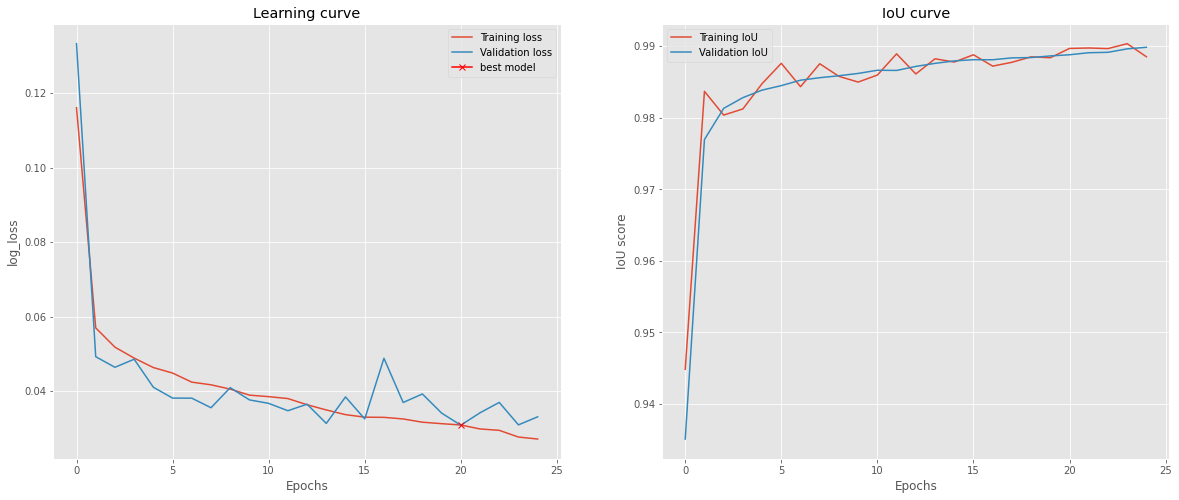

In [17]:
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(results.history["loss"], label="Training loss")
ax[0].plot(results.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(results.history["val_IoU"], label="Training IoU")
ax[1].plot(results.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();

Fascicle Training

In [18]:
# RUN ONLY ONCE WHEN CHANGING MODELS
# list of names of all images in the given path
im_width = 512
im_height = 512
idsF = next(os.walk("fasc_images_S"))[2] 
print("Total no. of fascicle images = ", len(idsF))
XF = np.zeros((len(idsF), im_height, im_width, 1), dtype=np.float32)
yF = np.zeros((len(idsF), im_height, im_width, 1), dtype=np.float32)

Total no. of fascicle images =  309


In [19]:
# RUN ONCE UPON STARTUP
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(idsF), total=len(idsF)):
    # Load images
    imgF = load_img("fasc_images_S/"+id_, color_mode = 'grayscale')
    x_imgF = img_to_array(imgF)
    x_imgF = resize(x_imgF, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    maskF = img_to_array(load_img("fasc_masks_S/"+id_, color_mode = 'grayscale'))
    maskF = resize(maskF, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    XF[n] = x_imgF/255.0
    yF[n] = maskF/255.0

<ipython-input-19-dfc0acdb4bf1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(idsF), total=len(idsF)):


  0%|          | 0/309 [00:00<?, ?it/s]

In [25]:
# RUN FOR EACH MODEL
# Split data into training and validation
X_trainF, X_validF, y_trainF, y_validF = train_test_split(XF, yF, test_size=0.1)

Text(0.5, 1.0, 'Mask only')

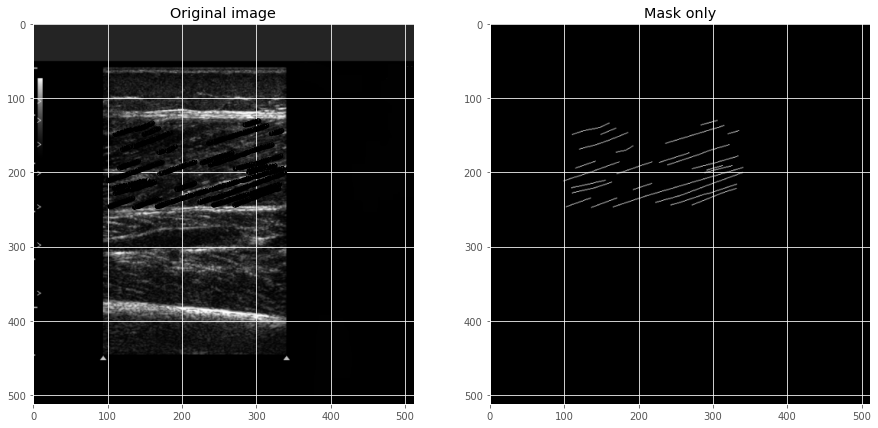

In [ ]:
# Example Visualization of the original image and mask -- fascicles
# Visualize a random image along with the mask (not necessary, just for checking)
ixF = random.randint(0, len(X_trainF))
has_maskF = y_trainF[ixF].max() > 0 # Check whether there's at least 1 fascicle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
ax1.imshow(X_trainF[ixF, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_maskF: # if at least 1 aponeurosis is present
    # draw the aponeuroses on the original image
    ax1.contour(y_trainF[ixF].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Original image')
ax2.imshow(y_trainF[ixF].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask only')

In [26]:
# RUN FOR EACH MODEL, CHANGE LEARNING RATE
# Compile the model
input_imgF = Input((im_height, im_width, 1), name='img')
modelF = build_vgg16_unet((512,512,1))
modelF.compile(optimizer=Adam(lr = 0.0001), loss="binary_crossentropy", metrics=["accuracy", IoU])
# modelF.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
# RUN FOR EACH MODEL, CHANGE LEARNING RATE AND CHANGE NAME OF MODEL SAVED
# Set some training parameters (e.g. the name you want to give to your trained model)
callbacksF = [
    EarlyStopping(patience=7, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('vgg_fascicles_1_try2_0001.h5', verbose=1, save_best_only=True, save_weights_only=False), # Name your model (the .h5 part)
    CSVLogger('fasc_training_0001.csv', separator=',', append=False)
]

In [28]:
resultsF = modelF.fit(X_trainF, y_trainF, batch_size=2, epochs=25, callbacks=callbacksF,\
                    validation_data=(X_validF, y_validF))

Epoch 1/25
139/139 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9919 - IoU: 0.9293
Epoch 1: val_loss improved from inf to 0.20268, saving model to vgg_fascicles_1_try2_0001.h5
139/139 [==============================] - 68s 473ms/step - loss: 0.0873 - accuracy: 0.9919 - IoU: 0.9293 - val_loss: 0.2027 - val_accuracy: 0.9911 - val_IoU: 0.8472 - lr: 1.0000e-04
Epoch 2/25
139/139 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9921 - IoU: 0.9665
Epoch 2: val_loss improved from 0.20268 to 0.05587, saving model to vgg_fascicles_1_try2_0001.h5
139/139 [==============================] - 70s 502ms/step - loss: 0.0420 - accuracy: 0.9921 - IoU: 0.9665 - val_loss: 0.0559 - val_accuracy: 0.9911 - val_IoU: 0.9544 - lr: 1.0000e-04
Epoch 3/25
139/139 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9921 - IoU: 0.9756
Epoch 3: val_loss improved from 0.05587 to 0.02996, saving model to vgg_fascicles_1_try2_0001.h5
139/139 [========

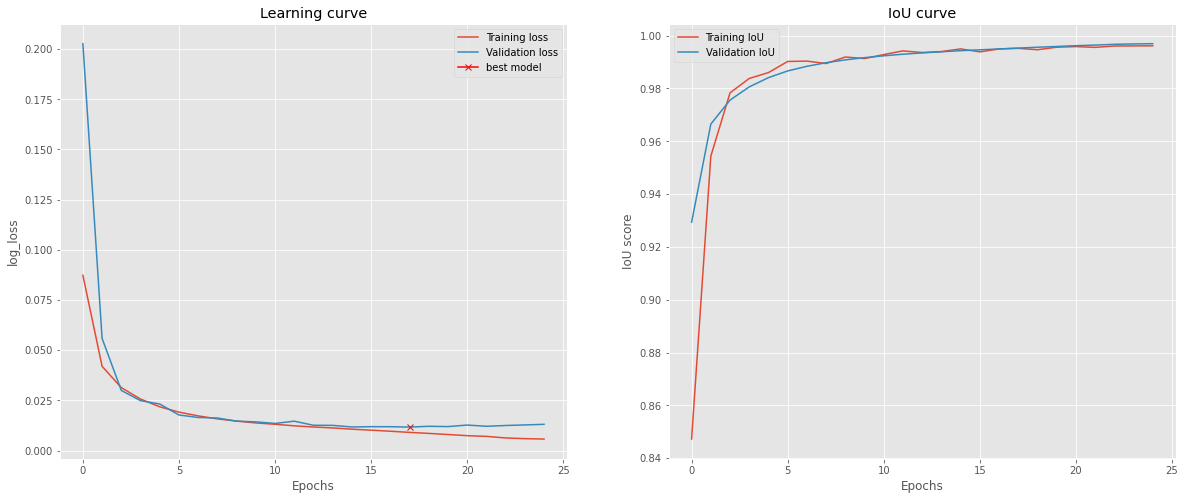

In [29]:
# Visualise the results of training
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(resultsF.history["loss"], label="Training loss")
ax[0].plot(resultsF.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(resultsF.history["val_loss"]), np.min(resultsF.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(resultsF.history["val_IoU"], label="Training IoU")
ax[1].plot(resultsF.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();